In [47]:
from random import randint
from datetime import date

import numpy as np

BASE_YEAR = 2022


class DataGenerator:
    base_storage = [50, 35, 82]
    base_delta = [(2, 6), (13, 25), (0, 8)]

    base_by = [(50, 100), (70, 80), (30, 45)]
    by_order = [30, 10, 15]

    special_delta_range = {
        (date(BASE_YEAR, 10, 1), date(BASE_YEAR, 11, 1)): [(0, 1), (28, 64), (0, 1)],
        (date(BASE_YEAR, 8, 1), date(BASE_YEAR, 9, 1)): [(28, 64), (0, 1), (0, 1)],
        (date(BASE_YEAR, 1, 1), date(BASE_YEAR, 3, 1)): [(0, 1), (0, 1), (28, 64)]
    }

    special_by_range = {
        (date(BASE_YEAR, 10, 1), date(BASE_YEAR, 11, 1)): [(0, 1), (28, 64), (0, 1)],
        (date(BASE_YEAR, 8, 1), date(BASE_YEAR, 9, 1)): [(28, 64), (0, 1), (0, 1)],
        (date(BASE_YEAR, 1, 1), date(BASE_YEAR, 3, 1)): [(0, 1), (0, 1), (28, 64)]
    }

    def __init__(self):
        self.storage = self.base_storage.copy()

    def generate(self, month: int, day: int) -> ([int], [int]):
        generate_date = date(BASE_YEAR, month, day)

        delta = self.base_delta
        for (start, stop), special_delta in self.special_delta_range.items():
            if start <= generate_date <= stop:
                delta = special_delta

        new_storage = [
            self.storage[index] - randint(start, stop)
            for index, (start, stop) in enumerate(delta)
        ]

        by = self.base_by
        for (start, stop), special_by in self.special_by_range.items():
            if start <= generate_date <= stop:
                by = special_by

        current_by = [
            randint(start, stop)
            for start, stop in by
        ]

        self.storage = [
            product + current_by[index] if product < self.by_order[index] else product
            for index, product in enumerate(self.storage)
        ]

        return new_storage, [
            product - new_storage[index]
            for index, product in enumerate(self.storage)
        ]





In [48]:
from datetime import timedelta

generator = DataGenerator()

def generate_for_year() -> []:
    data = []
    current_date = date(2022, 1, 1)
    while current_date < date(2023, 1, 1):
        month = current_date.month
        day = current_date.day
        storage, by = generator.generate(month, day)
        data.append(
            (([month, day] + storage), by)
        )

        current_date += timedelta(days=1)

    return data


In [49]:
data = []
for _ in range(100):
    data += generate_for_year()

In [50]:
valid_border = int(len(data)*9/10)
train = data[:valid_border]
validation = data[valid_border:]


In [51]:
import numpy as np
def prepare_data_to_np(data):
    return [
        (np.array(in_data), np.array(out_data))
        for in_data, out_data in data
    ]

train = prepare_data_to_np(train)
validation = prepare_data_to_np(validation)

def get_x(data):
    return np.array([
        in_data
        for in_data, _ in data
    ])

def get_y(data):
    return np.array([
        out_data
        for _, out_data in data
    ])

x_train = get_x(train)
y_train = get_y(train)

x_validation = get_x(validation)
y_validation = get_y(validation)

In [52]:
def normalize(data):
    transpose = list(zip(*data))
    maximus = [max(column) for column in  transpose]
    return [
        [item/maximus[index] for index, item in enumerate(row)]
        for row in data
    ]

In [53]:
x_train = normalize(x_train)
y_train = normalize(y_train)

x_validation = normalize(x_validation)
y_validation = normalize(y_validation)

In [54]:
from keras.layers import Dense
from keras import Sequential, Input

model = Sequential()
model.add(Input(5))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(8, activation='elu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')


In [55]:
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_validation, y_validation))

Epoch 1/100
33/33 [==============================] - 2s 28ms/step - loss: 0.5879 - accuracy: 0.7742 - val_loss: 0.4981 - val_accuracy: 0.9123
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4368 - accuracy: 0.9160 - val_loss: 0.3866 - val_accuracy: 0.9342
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 0.3606 - accuracy: 0.9648 - val_loss: 0.3412 - val_accuracy: 0.9942
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.3297 - accuracy: 0.9993 - val_loss: 0.3230 - val_accuracy: 1.0000
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 0.3176 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 1.0000
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 0.3131 - accuracy: 1.0000 - val_loss: 0.3135 - val_accuracy: 1.0000
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3111 - accuracy: 1.0000 - val_loss: 0.3120 - val_accuracy: 1.0000
Epoch 8/1

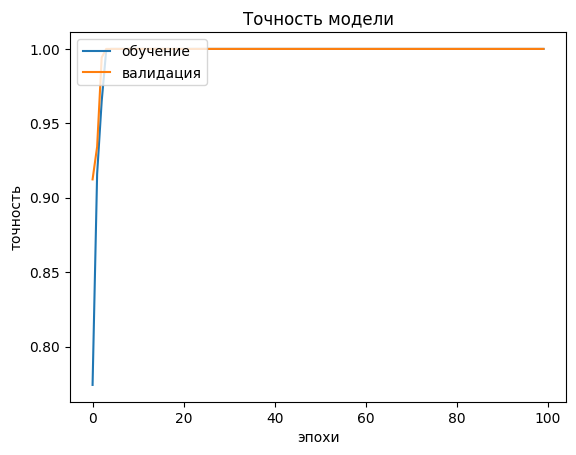

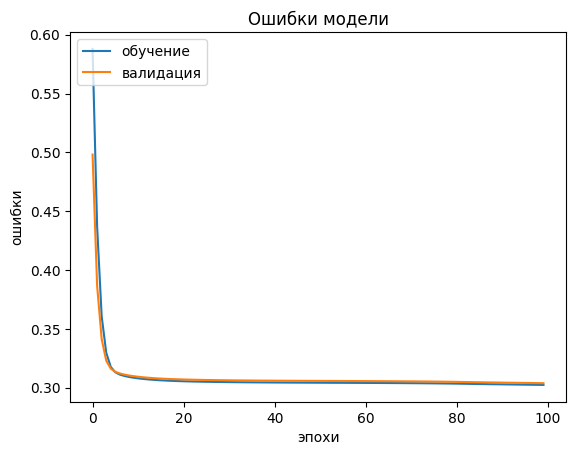

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпохи')
plt.legend(['обучение', 'валидация'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Ошибки модели')
plt.ylabel('ошибки')
plt.xlabel('эпохи')
plt.legend(['обучение', 'валидация'], loc='upper left')
plt.show()